In [96]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
# import seaborn as sns
# from statsmodels import api
from scipy import stats
from scipy.optimize import minimize 
import json
# import pprint


In [97]:
# This function cleans the data and creates c_0, c_f, and log_c_f

def cleanData(df):
    # Remove unnecessary columns
    df = df.drop('Link', axis=1)
    if df['Cited by'].isna().sum() > 0:
        print("HEEEEEEJ")
    df = df[df['Cited by'] > 0]
    c_0_list = []

    # Calc c_0
    c_0 = {year : df.loc[df['Year'] == year, 'Cited by'].mean() for year in range(2001,2020)}

    for index, row in df.iterrows():
        c_0_list.append(c_0[row['Year']])
        #df['c_0'][index] = c_0[row['Year']]
    df['c_0'] = c_0_list
    # Calc c_f
    df['c_f'] = df['Cited by'] / df['c_0']
    df['c_f'].astype(np.float64)

    df['log_c_f'] = np.log(df['c_f'])

    return df


In [98]:
# Load data sets

sen_tec = pd.read_csv('sensor_technology.csv')
col_sys = pd.read_csv('Swarming_MultiAgent.csv')
tec_mob = pd.read_csv('Robotics.csv')
cont_alg = pd.read_csv('ControlSystems_Algorithms.csv')
loc_map = pd.read_csv('Localization_mapping.csv')
sen_fus = pd.read_csv('sensor_fusion.csv')
ai_ml = pd.read_csv('AI_ML.csv')
edg_com = pd.read_csv('EdgeComputing.csv')
com_net = pd.read_csv('Communications_Networking.csv')
ene_mgm = pd.read_csv('EnergyManagement.csv')
sim_mod = pd.read_csv('Simulation_Modeling.csv')
hum_man  = pd.read_csv('HumanMachineInteraction.csv')
cyb_sec = pd.read_csv('CyberSecurity.csv')
eth_reg =pd.read_csv('EthicsRegulations.csv')


dataSets = [sen_tec, col_sys, tec_mob, cont_alg, loc_map, sen_fus, ai_ml, edg_com, com_net, ene_mgm, sim_mod, hum_man, cyb_sec, eth_reg]
keyNames = ["sen_tec", "col_sys", "tec_mob", "cont_alg", "loc_map", "sen_fus", "ai_ml", "edg_com", "com_net", "ene_mgm", "sim_mod", "hum_man", "cyb_sec", "eth_reg"]

In [99]:
# This function defines the log-likelihood function that is used in the optimisation

def get_opti_fun(df):
   # MLE function
   def MLE_Norm(parameters):
      # extract parameters
      mu, sigma = parameters
      # Calculate the log-likelihood for normal distribution
      ##LL = np.sum(stats.norm.logpdf(df['log_c_f'], loc=mu, scale=sigma))
      LL = np.sum(stats.lognorm.logpdf(x= df["c_f"].values, loc = mu, s = sigma))
      
      # Calculate the negative log-likelihood
      neg_LL = -1*LL
      return neg_LL
   return MLE_Norm



In [100]:
def MLE(dataSets):    
    dist = stats.lognorm
    bounds = {
        'loc': (0,1),
        's': (0,2),
        'scale': (0,2)
    }
    #bounds = [(0,2), (0,1), (0,5)]
    parameterDict = {}

    for index, df in enumerate(dataSets):
        df = cleanData(df)
        res = stats.fit(dist, df['c_f'].values, bounds, method='mle')
        print(res)
        parameterDict.update({keyNames[index]: {'mu': res.params.loc}})
        parameterDict[keyNames[index]].update({'sigma': res.params.s})
    return parameterDict

In [101]:
# Function that performs the maximum likelihood-estimation. Outputs a dict of parameters for each technology

def MLE_estimation(dataSets, keyNames):

    parameterDict = {}
    initParams = [0.5, 1.0]
    
    for index, df in enumerate(dataSets):
        df = cleanData(df)

        mle = minimize(get_opti_fun(df), initParams)
        print(mle)
        mu = mle.x[0]
        sigma = mle.x[1]
        parameterDict.update({keyNames[index]: {'mu': mu}})
        parameterDict[keyNames[index]].update({'sigma': sigma})

    return parameterDict

        

In [102]:
# Perform the estimation

parameters = MLE(dataSets)

/opt/homebrew/anaconda3/envs/exjobb/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:1636: RuntimeWarning: overflow encountered in divide
  x = asarray((x-loc) / scale)


  params: FitParams(s=1.759646147516468, loc=0.036508057974210265, scale=0.2557708595020566)
 success: True
 message: 'Optimization terminated successfully.'
  params: FitParams(s=1.6433457992678406, loc=0.03083220293889538, scale=0.304286282637022)
 success: True
 message: 'Optimization terminated successfully.'
  params: FitParams(s=1.6505146523063874, loc=0.03072234800306297, scale=0.27390033591202023)
 success: True
 message: 'Optimization terminated successfully.'


/opt/homebrew/anaconda3/envs/exjobb/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:1636: RuntimeWarning: overflow encountered in divide
  x = asarray((x-loc) / scale)


  params: FitParams(s=1.7202682953694894, loc=0.03713869508810524, scale=0.25443715477605666)
 success: True
 message: 'Optimization terminated successfully.'


/opt/homebrew/anaconda3/envs/exjobb/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:1636: RuntimeWarning: overflow encountered in divide
  x = asarray((x-loc) / scale)


  params: FitParams(s=1.5625692041591335, loc=0.017309581203878405, scale=0.282450592840943)
 success: True
 message: 'Optimization terminated successfully.'
  params: FitParams(s=1.6947861078435191, loc=0.029984160671079396, scale=0.28361132942673684)
 success: True
 message: 'Optimization terminated successfully.'


/opt/homebrew/anaconda3/envs/exjobb/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:1636: RuntimeWarning: overflow encountered in divide
  x = asarray((x-loc) / scale)


  params: FitParams(s=1.5478491590605128, loc=0.01980959147738733, scale=0.3091008924334433)
 success: True
 message: 'Optimization terminated successfully.'
  params: FitParams(s=1.4821192968671864, loc=0.0016802180733292427, scale=0.3207417593758124)
 success: True
 message: 'Optimization terminated successfully.'
  params: FitParams(s=1.4921182579295824, loc=0.01155979923585898, scale=0.30209757881301746)
 success: True
 message: 'Optimization terminated successfully.'


/opt/homebrew/anaconda3/envs/exjobb/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:1636: RuntimeWarning: overflow encountered in divide
  x = asarray((x-loc) / scale)


  params: FitParams(s=1.5396495746623593, loc=0.017400150726867743, scale=0.318308120070762)
 success: True
 message: 'Optimization terminated successfully.'
  params: FitParams(s=1.7411685159369044, loc=0.04011162320511941, scale=0.27914667235465074)
 success: True
 message: 'Optimization terminated successfully.'
  params: FitParams(s=1.608676651949756, loc=0.032303353442975635, scale=0.30220911697923836)
 success: True
 message: 'Optimization terminated successfully.'


/opt/homebrew/anaconda3/envs/exjobb/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:1636: RuntimeWarning: overflow encountered in divide
  x = asarray((x-loc) / scale)


  params: FitParams(s=1.6925803472227967, loc=0.037615798000437684, scale=0.28146136228471696)
 success: True
 message: 'Optimization terminated successfully.'
  params: FitParams(s=1.4480544607939922, loc=0.016017048669730072, scale=0.37923520161397684)
 success: True
 message: 'Optimization terminated successfully.'


In [103]:
parameters

{'sen_tec': {'mu': 0.036508057974210265, 'sigma': 1.759646147516468},
 'col_sys': {'mu': 0.03083220293889538, 'sigma': 1.6433457992678406},
 'tec_mob': {'mu': 0.03072234800306297, 'sigma': 1.6505146523063874},
 'cont_alg': {'mu': 0.03713869508810524, 'sigma': 1.7202682953694894},
 'loc_map': {'mu': 0.017309581203878405, 'sigma': 1.5625692041591335},
 'sen_fus': {'mu': 0.029984160671079396, 'sigma': 1.6947861078435191},
 'ai_ml': {'mu': 0.01980959147738733, 'sigma': 1.5478491590605128},
 'edg_com': {'mu': 0.0016802180733292427, 'sigma': 1.4821192968671864},
 'com_net': {'mu': 0.01155979923585898, 'sigma': 1.4921182579295824},
 'ene_mgm': {'mu': 0.017400150726867743, 'sigma': 1.5396495746623593},
 'sim_mod': {'mu': 0.04011162320511941, 'sigma': 1.7411685159369044},
 'hum_man': {'mu': 0.032303353442975635, 'sigma': 1.608676651949756},
 'cyb_sec': {'mu': 0.037615798000437684, 'sigma': 1.6925803472227967},
 'eth_reg': {'mu': 0.016017048669730072, 'sigma': 1.4480544607939922}}

In [104]:
with open("distribution_params.json", "w") as write_file:
    json.dump(parameters, write_file, indent=4)

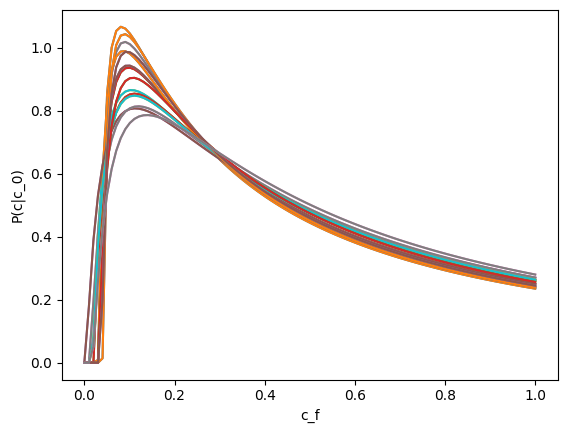

In [105]:
def plot_dist2(dataSets, parameters=parameters, keyNames=keyNames):
    
    key_names = ["sen_tec", "col_sys", "tec_mob", "cont_alg", "loc_map", "sen_fus", "ai_ml", "edg_com", "com_net", "ene_mgm", "sim_mod", "hum_man", "cyb_sec", "eth_reg"]
    
    for index, df in enumerate(dataSets):
        mu = parameters[keyNames[index]]["mu"]
        sigma = parameters[keyNames[index]]["sigma"]
        dist = stats.lognorm(loc=mu, s = sigma)
        
        x = np.linspace(0,1,100)
        
        p = dist.pdf(x)
        
        
        plt.plot(x,p)
        #plt.legend(key_names, )
        plt.xlabel("c_f")
        plt.ylabel("P(c|c_0)")
        #plt.xscale("log")
        #plt.yscale("log")
        plt.plot(x,p)

plot_dist2(dataSets)